# Sportsbook ESPN Player Handle Validation: Part 2

In the first notebook, you completed the following:
1. Loaded in partitioned data from GCS and joined features and actuals
2. Set up a custom train-test-split function, which takes an `test_date` and splits the dataset
3. Trained a baseline model with 2 features
4. Evaluated the accuracy and achieved a decent R^2 = 0.21 as a starting point

Nice work so far! In this notebook, we will expand on the first one and complete the following:
1. Recap and load in everything from the first notebook as a starting point
2. Examine feature importance using SHAP and add more features
3. Use a `for` loop to test on multiple test dates
4. Plot the results so we can visualize them

## Step 0: Imports

In addition to the imports from last time, we will also include `shap` for feature importance. To use `shap`, we will call the `.initjs()` method, which allows javascript to run in a Jupyter notebook. This just allows the plots to render nicely and its been added below.

We also include `joblib` which can be handy for saving python variables. If you have a long-running job, you may want to save results so you don't have to run it all over again the next day!

In [1]:
# !pip install -q dask[complete] catboost shap

In [50]:
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
import shap
import joblib

from typing import Tuple, List
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_absolute_error

# graphs
import plotly.express as px

# notification sound
from IPython.display import Audio
notify_me = Audio(filename = 'pop_notification.wav', rate = 4410, autoplay=True)

pd.options.display.max_columns = None # display all columns

In [3]:
shap.initjs()

## Step 1: Recap and starting where we left off
In this section, you will load and re-run all the functions you implemented in the previous notebook. We will start where we left off in the previous notebook!

For some of these functions, we will re-use them later on. That is one of the main benefits of writing code as functions: **reusability!** 

In [4]:
STORAGE_BUCKET = 'non-prod-data-eng-dev-dsml'
GCS_PATH = 'training-storage/espn-player-handle-forecast/sportsbook_retention/{query_type}'

In [5]:
def load_and_join_actuals_with_features() -> pd.DataFrame:
    """
    Loads all actuals and features partitions in GCS using dask and
    converts to pandas dataframe. Joins actuals with features and returns
    the joined pandas dataframe.
    
    Returns
    -------
    pd.DataFrame
        Dataframe of grain 1 row per user and predicted_on_date, with
        all actuals (y) and features (X)
    """
    # Read in actuals df using dask and convert to pandas df
    actuals_path = GCS_PATH.format(query_type='actuals')
    full_path = f'gs://{STORAGE_BUCKET}/{actuals_path}/date=*/train_*.parquet'
    df_actuals = dd.read_parquet(full_path).compute()
    
    # Read in features df using dask and convert to pandas df
    features_path = GCS_PATH.format(query_type='features')
    full_path = f'gs://{STORAGE_BUCKET}/{features_path}/date=*/train_*.parquet'
    df_features = dd.read_parquet(full_path).compute()
    
    # Join actuals with features and return    
    return df_features.merge(df_actuals, how='inner', on=['user_id', 'predicted_on_date'])

In [6]:
df = load_and_join_actuals_with_features()
df.sample(3)

,user_id,predicted_on_date,days_since_first_bet,activedays_prev_1_day,activedays_prev_3_to_2_days,activedays_prev_7_to_4_days,activedays_prev_15_to_8_days,activedays_prev_31_to_16_days,activedays_prev_63_to_32_days,handle_prev_1_day,handle_prev_3_to_2_days,handle_prev_7_to_4_days,handle_prev_15_to_8_days,handle_prev_31_to_16_days,handle_prev_63_to_32_days,n_straights,pct_straights,n_parlays,pct_parlays,n_parlay_plus,pct_parlay_plus,n_teasers,pct_teasers,vip_status,n_nhl_legs,n_nfl_legs,n_mlb_legs,n_nba_legs,n_ncaab_legs,n_ncaaf_legs,crs_pregame,crs_live,eod_cash_balance,date_x,activedays_7_days,activedays_14_days,handle_7_days,handle_14_days,date_y
65103392,51a483fd-cbb8-4edb-96de-18ec36331d21,2024-07-11,557,1,1,1,4,10,23,25.0,35.0,30.0,145.0,419.0,2820.0,512,0.960600,4,0.007505,17,0.031895,0,0.0,Non-VIP,3,46,61,376,3,1,0.1,0.01,68.91,2024-07-11,0,0,0.0,0.0,2024-07-11
3116786,b162a507-b69d-45aa-8b36-59d6d6990771,2024-03-05,60,0,1,1,0,0,7,0.0,0.0,10.0,0.0,0.0,270.0,0,0.000000,0,0.000000,13,1.000000,0,0.0,Non-VIP,0,15,0,168,0,0,1.0,1.00,0.00,2024-03-05,2,2,25.0,25.0,2024-03-05
53557304,73d9e05a-67f2-4598-8618-bf00a1799850,2024-06-03,200,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,36,0.130909,88,0.320000,151,0.549091,0,0.0,Non-VIP,84,418,0,1307,89,23,1.0,1.00,0.74,2024-06-03,1,1,0.0,0.0,2024-06-03


In [36]:
# print(min(df['predicted_on_date']))

2024-03-01


In [37]:
# print(max(df['predicted_on_date']))

2024-07-11


In [7]:
def time_aware_train_test_split(df: pd.DataFrame,
                                test_date: datetime.date) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Given an input df containing all data and a column `predicted_on_date`, perform a
    time-aware train test split using the input `test_date`. All data prior to `test_date`
    is used for training. All data exactly on the `test_date` is used for testing.
    
    Params
    ------
    df : pd.DataFrame
        df of all data, features and actuals across all dates.
    test_date: datetime.date
        The test date used for splitting
        
    Returns
    -------
    Tuple[pd.DataFrame, pd.Dataframe]
        The training set and the test set, respectively
    """
    # All data prior to `test_date` are used for training
    df_train = df.loc[df["predicted_on_date"] < test_date]
    
    # All data exactly on `test_date` is used for testing
    df_test = df.loc[df["predicted_on_date"] == test_date]
    
    return df_train, df_test

In [8]:
test_date = pd.Timestamp('2024-06-01').date()
print(f'Test date: {test_date}')

Test date: 2024-06-01


In [9]:
df_train, df_test = time_aware_train_test_split(df, test_date)

In [10]:
def train_catboost_model(df_train: pd.DataFrame, y_name: str, X_names: List[str]) -> CatBoostRegressor:
    """
    Train a catboost model to predict df[y_name] using df[X_Names]
    
    Params
    ------
    df_train : pd.DataFrame
        Training dataset of features and actuals
    y_name : str
        Name of column containing the outcome variable
    X_names : List[str]
        List of name(s) of column(s) containing the features
        
    Returns
    -------
    CatboostRegressor
        Trained catboost regressor model
    """
    # Extract outcome variable and features from df_train
    y_train = df_train[y_name]
    X_train = df_train[X_names]
    
    # Instantiate model and pool dataset
    model = CatBoostRegressor(eval_metric="RMSE", verbose=300)
    
    train_pool = Pool(X_train, y_train)
    
    # Train model
    model.fit(train_pool)
    
    return model

In [11]:
model = train_catboost_model(df_train=df_train, y_name='handle_7_days', X_names=['handle_prev_1_day', 'handle_prev_3_to_2_days'])

Learning rate set to 0.227986
0:	learn: 5448.5964944	total: 648ms	remaining: 10m 47s
300:	learn: 5212.6475449	total: 2m 48s	remaining: 6m 30s
600:	learn: 5212.2697758	total: 5m 37s	remaining: 3m 44s
900:	learn: 5212.0926899	total: 8m 28s	remaining: 55.9s
999:	learn: 5212.0486629	total: 9m 25s	remaining: 0us


In [12]:
def evaluate_accuracy(model: CatBoostRegressor,
                      df_test: pd.DataFrame,
                      y_name: str,
                      X_names: List[str]) -> Tuple[float, float, np.array]:
    """
    Given a trained model and a test set, evaluate model accuracy.
    First we generate predictions using df_test[X_names]. Then we compare
    the predictions to df_test[y_name] to calculate R^2 and MAE.
    
    Params
    ------
    model : CatBoostRegressor
        Trained Catboost model
    df_test : pd.DataFrame
        Test dataset containing features and actuals
    y_name : str
        Name of column containing the outcome variable
    X_names : List[str]
        List of name(s) of column(s) containing the features
        
    Returns
    -------
    Tuple[float, float]
        The R^2 and MAE metrics, respectively
    np.array
        The raw predictions
    """
    # Generate predictions
    predictions = model.predict(df_test[X_names])
    
    # Compute metrics
    r2 = r2_score(df_test[y_name], predictions)
    mae = mean_absolute_error(df_test[y_name], predictions)
    
    return r2, mae, predictions

In [13]:
r2, mae, predictions = evaluate_accuracy(model=model, df_test=df_test, y_name=['handle_7_days'], X_names=['handle_prev_1_day', 'handle_prev_3_to_2_days'])

In [14]:
print(f'R^2: {round(r2, 2)}, MAE: {round(mae, 2)}')

R^2: 0.21, MAE: 162.7


In [15]:
notify_me

## Step 2: Feature Importance & Adding More Features

Before we add more features, lets set up SHAP so we can see which features are the most important. This is an important step because:
1. Instead of just simply throwing data into a black box (your model), understanding feature importance gives you a sense of which inputs are most impactful to generating predictions.
2. Often times, stakeholders want to know which inputs drive a prediction. If you can tell them which are the top 3 for example, this goes a long way to earning their trust.

To do this, we will use the `shap` library. It is a fantastic library for understanding both the importance and directionality of features:
1. **Importance**: How much does this feature contribute to the model's predictions?
2. **Directionality**: Is the contribution positive (higher feature value --> higher prediction) or negative (higher feature value --> lower prediction)

### Step 2.1: Feature Importance
Unlike the previous notebook, this time, I am leaving more of the functions open ended. You will have to do more reading of the documentation and coding yourself. Here are some helpful hints:
* Read the docstring in full. This has some helpful hints on how to set up the input parameters you will need
* One of the input parameters is optional with a default value. Read more on how to set this up [here](https://www.geeksforgeeks.org/default-arguments-in-python/)
* In the previous notebook, you selected specific rows of a df. In this case, you'll need to select specific columns. Take a look on how to do this [here](https://pandas.pydata.org/docs/user_guide/indexing.html)
* There are lots of different `shap` Explainers, and you'll have to choose the correct one based on the model (CatBoost)
    * Peek under the hood and read about what kind of model CatBoost is [here](https://catboost.ai/en/docs/concepts/algorithm-main-stages)
    * See the different shap Explainers [here](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html)
* Once you calculate `shap_values`, you can plot them in lots of different ways. Try a `.summary_plot()` first, but you can take a look at the others [here](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)

Since this notebook is more open ended, try to have fun with it! As long as you arrive at a good understanding of feature importance, that is all that matters. Feel free to diverge from the template I've laid out here if you so choose.

In [16]:
def plot_shap_feature_importance(model: CatBoostRegressor,
                                 df_train: pd.DataFrame,
                                 X_names : List[str],
                                 n_sample: int = 100000 # set default of 100,000
                                 ) -> None: 
    
    """
    Plot feature importance using shap summary plot.
    
    This model takes as input a trained CatBoost regressor, the training dataset,
    and a list of feature names. Calling this function will plot a shap summary plot
    showing the feature importances and directionality.
    
    There is one optional input parameter, n_sample (default: 100000) which will downsample
    the training dataset to save time, as shap values are quite expensive to compute.
    
    Params
    ------
    model : CatBoostRegressor
        A trained CatBoost model that we want to examine feature importance for
    df_train : pd.DataFrame
        Training dataset that was used to train the Catboost model
    X_names : List[str]
        List of feature names
    n_sample: int (default: 100000)
    
    Note:
    - Call the function and it just shows the plot right away ( -> None)
    - The function returns a plot object, which you then have to show (example: from typing import union:  -> Union[int, float, None]) 
    
    """
    # Filter df_train to contain only the input feature names
    df_train = df_train[X_names]
    
    # Sample to n_sample rows
    df_train = df_train.iloc[:n_sample]
    
    # Compute shap values using the appropriate shap explainer
    # Catboost Regressor uses gradient-boosted decision trees -> shape.TreeExplainer()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(df_train)

    # Plot the shap summary plot
    shap.summary_plot(shap_values)

In [114]:
numeric_features = [
            'days_since_first_bet',
            
            'activedays_prev_1_day', 
            'activedays_prev_3_to_2_days',
            'activedays_prev_7_to_4_days', 
            'activedays_prev_15_to_8_days',
            'activedays_prev_31_to_16_days', 
            'activedays_prev_63_to_32_days',
            
            'handle_prev_1_day', 
            'handle_prev_3_to_2_days',
            'handle_prev_7_to_4_days', 
            'handle_prev_15_to_8_days',
            'handle_prev_31_to_16_days', 
            'handle_prev_63_to_32_days', 
            
            'n_straights',
            'pct_straights', 
            'n_parlays', 
            'pct_parlays', 
            'n_parlay_plus',
            'pct_parlay_plus', 
            'n_teasers', 
            'pct_teasers', 
            
            'n_nhl_legs', 
            'n_nfl_legs', 
            'n_mlb_legs', 
            'n_nba_legs', 
            'n_ncaab_legs',
            'n_ncaaf_legs', 
            
            'crs_pregame', 
            'crs_live', 
            
            'eod_cash_balance'

            # actuals
            
            # 'activedays_7_days', 
            # 'activedays_14_days', 
            # 'handle_7_days',
            # 'handle_14_days', 
           ]

categorical_features = ['vip_status']

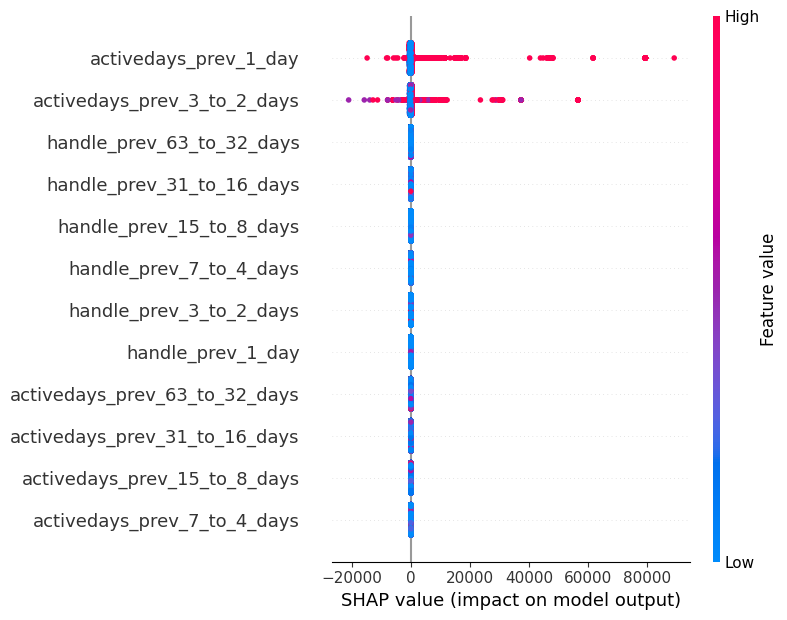

In [18]:
# Call the function and view the results!
plot_shap_feature_importance(model=model, df_train=df_train, X_names=numeric_features)

### Step 2.2: Add more features

Now that we have a function to examine feature importances, lets add more features to the model. But first, we will have to make an adjustment to one of the functions above, specifically, `train_catboost_model()`.

To be even more specific, one of the strengths of CatBoost is that it can natively handle categorical features with no preprocessing. This is very handy and saves you a lot of time and effort. However, you do need to specify which of your features is categorical. Read these examples and modify the function so that it can also handle categorical variables: https://catboost.ai/en/docs/concepts/python-usages-examples

**Hint**:
* You want the function to work regardless of whether categorical features are inputted or not. You may find optional parameters with default values helpful in this context!
* You will need to add one more input parameter to this function, which specifies which features are categorical

In [19]:
def train_catboost_model_with_cat_features(df_train: pd.DataFrame, y_name: str, X_names: List[str], cat_features: List[str]) -> CatBoostRegressor:
    """
    Train a catboost model to predict df[y_name] using df[X_Names]
    
    Params
    ------
    df_train : pd.DataFrame
        Training dataset of features and actuals
    y_name : str
        Name of column containing the outcome variable
    X_names : List[str]
        List of name(s) of column(s) containing the features
    cat_features : List[str], Optional (default: None)
        List of features which are categorical
        
    Returns
    -------
    CatboostRegressor
        Trained catboost regressor model
    """
    # Extract outcome variable and features from df_train
    y_train = df_train[y_name]
    X_train = df_train[X_names]
    
    # Instantiate model and pool dataset
    model = CatBoostRegressor(eval_metric="RMSE", verbose=300)
    
    # If there are categorical features, setup train_pool one way
    if ['vip_type'] in X_names:
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
    
    # Otherwise, set it up the way it was before
    else:
        train_pool = Pool(X_train, y_train)
    
    # Train model
    model.fit(train_pool)
    
    return model

Now you can try adding more features to the model! Try adding the categorical variable from the dataset to see if the function works!

In [20]:
model = train_catboost_model_with_cat_features(df_train=df_train, y_name='handle_7_days', X_names=numeric_features, cat_features=categorical_features)

Learning rate set to 0.227986
0:	learn: 5399.5577738	total: 705ms	remaining: 11m 44s
300:	learn: 3764.1879842	total: 3m 10s	remaining: 7m 22s
600:	learn: 3518.3182293	total: 6m 20s	remaining: 4m 12s
900:	learn: 3369.5624885	total: 9m 31s	remaining: 1m 2s
999:	learn: 3319.1923984	total: 10m 34s	remaining: 0us


You can also re-use one of your previous functions to examine if accuracy is increased once you add more features:

In [21]:
r2, mae, predictions = evaluate_accuracy(model=model, df_test=df_test, y_name=['handle_7_days'], X_names=numeric_features)

In [22]:
print(f'R^2: {round(r2, 2)}, MAE: {round(mae, 2)}')

R^2: 0.11, MAE: 157.23


And of course, lets look at feature importance as well:

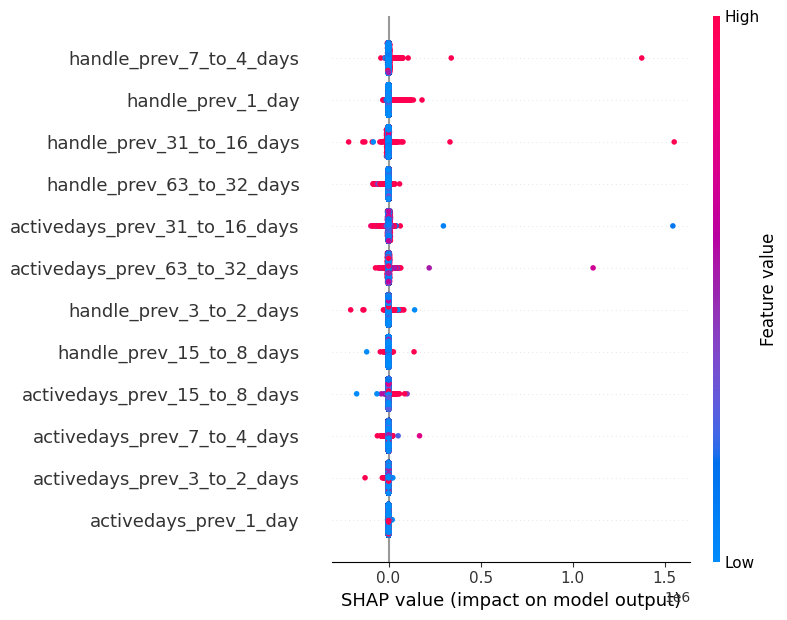

In [23]:
plot_shap_feature_importance(model=model, df_train=df_train, X_names=numeric_features)

In [24]:
notify_me

## Step 3: Multiple Test Dates

Things are looking good so far on 1 test date, specifically `2024-06-01`. To get even more confidence that the model will work in production, lets try it out on multiple test dates and make sure we aren't overfitting to data on a particular date.

The best way to do this in python is with a `for` loop. Read more about this here!: https://www.w3schools.com/python/python_for_loops.asp

Additionally, you'll want to store your accuracies (`r2` and `mae`) for each iteration so you can view and plot them later. One handy way to do this is with a python dictionary: https://www.w3schools.com/python/python_dictionaries_loop.asp

**Hints**
* Since the model takes ~20 minutes to train, the more test dates you add, the longer your loop will run for. You can always leave this running and come back later :)
* The decision of how many test dates to include is subjective. Try at least 3, which will run for ~1 hour.
* Within the for loop, it can be helpful to add some `print` statements, so you can see the progess!
* You should re-use the functions you've already written!
* Since all this code takes a while to run, you might want to test out your loop and dictionary on some dummy data first. If that works, then you can go for the real deal!

In [116]:
# Define a list of test dates (use at least 3)
dates = ['2024-03-29', '2024-04-01', '2024-4-20', '2024-05-02', '2024-05-23', '2024-06-03', '2024-06-24', '2024-07-11']

# convert from string to datetime so the comparison date < prediction_dates works
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates] 

In [45]:
# Define a dictionary to keep track of r2 and mae scores for each iteration
eval_dict = {}

In [46]:
# Implement the for loop
for date in test_dates:
    # Train-test-split with this test date
    df_train, df_test = time_aware_train_test_split(df, date)
    
    # Train model
    model = train_catboost_model_with_cat_features(df_train=df_train, y_name='handle_7_days', X_names=numeric_features, cat_features=categorical_features)
    
    # Score accuracy
    r2, mae, predictions = evaluate_accuracy(model=model, df_test=df_test, y_name='handle_7_days', X_names=numeric_features)
    
    # Save accuracy in dictionary so we can view it later
    eval_dict[date] = [r2,mae]

Learning rate set to 0.195677
0:	learn: 5735.4795141	total: 305ms	remaining: 5m 4s
300:	learn: 3102.0450381	total: 1m 16s	remaining: 2m 58s
600:	learn: 2745.1476180	total: 2m 34s	remaining: 1m 42s
900:	learn: 2593.8698427	total: 3m 53s	remaining: 25.6s
999:	learn: 2563.9795368	total: 4m 19s	remaining: 0us
Learning rate set to 0.217593
0:	learn: 5941.7174193	total: 550ms	remaining: 9m 9s
300:	learn: 3920.8753074	total: 2m 23s	remaining: 5m 33s
600:	learn: 3560.6002843	total: 4m 46s	remaining: 3m 10s
900:	learn: 3325.4578618	total: 7m 14s	remaining: 47.8s
999:	learn: 3264.9308028	total: 8m 2s	remaining: 0us
Learning rate set to 0.228503
0:	learn: 5369.3078777	total: 710ms	remaining: 11m 49s
300:	learn: 3699.1065777	total: 3m 16s	remaining: 7m 36s
600:	learn: 3428.1061597	total: 6m 33s	remaining: 4m 21s
900:	learn: 3257.6387000	total: 9m 48s	remaining: 1m 4s
999:	learn: 3221.5707525	total: 10m 52s	remaining: 0us


In [47]:
eval_dict

{datetime.date(2024, 4, 1): [0.2853327875181161, 159.94512264037687],
 datetime.date(2024, 5, 2): [0.06204073843730529, 151.868416613096],
 datetime.date(2024, 6, 3): [0.19176329480639465, 159.28073107791613]}

Finally, because the cell above will take quite a bit of time to run, we should probably save the results in a persisted way so we don't need to re-run the training every time.

You can do this with `joblib`, which can save any python variable to a local file as a pickle `.pkl`. 
* `joblib.dump(my_variable, 'my_variable.pkl')`
* `my_variable = joblib.load('my_variable.pkl')`

In [55]:
# Save your accuracy dictionary in case you need to reload it later
joblib.dump(eval_dict, 'second_test_model.pkl')

['first_test_model.pkl']

In [56]:
notify_me

## Step 4: Plotting
In the final step, lets plot the `r2` and `mae` scores across the various test dates so we can easily visualize the results!

Python has a lot of different options for plotting. You can read about them here: https://mode.com/blog/python-data-visualization-libraries

Choose 1 plotting library and produce the following plots for `r2` and `mae`
* X axis: your test dates
* Y axis: your accuracy metric

**Bonus**: If you're feeling up for it, write a function which you can re-use to plot either `r2` or `mae`! 

In [82]:
eval_data = joblib.load('second_test_model.pkl')
#eval_data[datetime.date(2024, 4, 1)]

In [63]:
eval_data

{datetime.date(2024, 4, 1): [0.2853327875181161, 159.94512264037687],
 datetime.date(2024, 5, 2): [0.06204073843730529, 151.868416613096],
 datetime.date(2024, 6, 3): [0.19176329480639465, 159.28073107791613]}

In [83]:
# eval_data[datetime.date(2024, 4, 1)][0]

In [110]:
plot_data = pd.DataFrame.from_dict(eval_data, orient='index',columns=['R2', 'MAE'] ) # convert dictionary into dataframe with prediction date as index
plot_data.index.names = ['prediction_date']                                          # rename index
plot_data.reset_index(inplace = True)                                                # remove prediction date index, convert to basic numeric index
plot_data

,prediction_date,R2,MAE
0,2024-04-01,0.285333,159.945123
1,2024-05-02,0.062041,151.868417
2,2024-06-03,0.191763,159.280731


In [111]:
# create a function to plot mae or r2
def plot_eval_metrics(data: pd.DataFrame, x_axis: list, y_axis: list) -> None: 
    
    fig = px.line(data, data[x_axis], data[y_axis])
    fig.show()

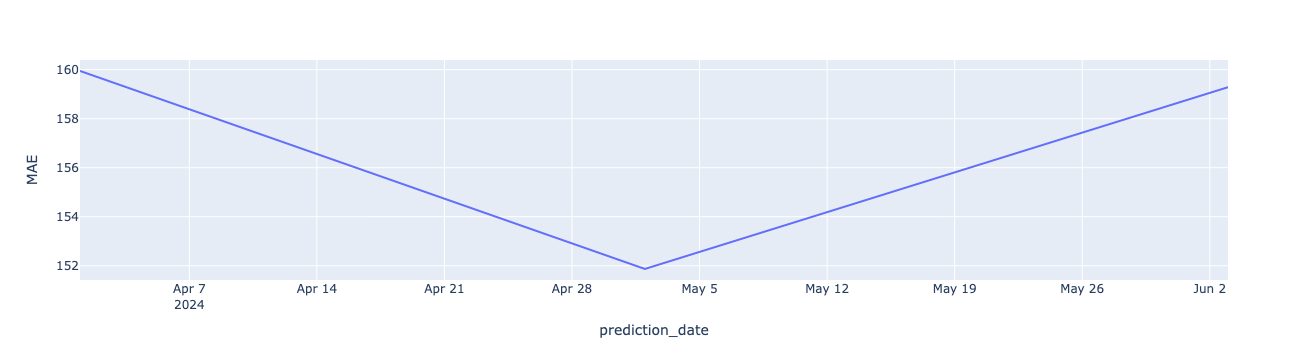

In [112]:
# plot MAE
plot_eval_metrics(data=plot_data, x_axis='prediction_date', y_axis='MAE')

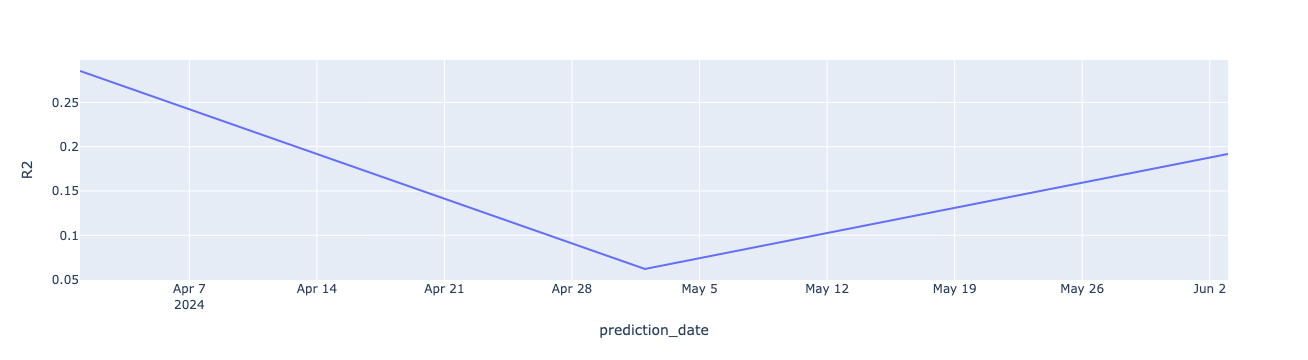

In [113]:
# plot R2
plot_eval_metrics(data=plot_data, x_axis='prediction_date', y_axis='R2')

In [99]:
notify_me